# Simulation to generate initial conditions

In [1]:
%%time
import rebound
import reboundx
import numpy as np
from collections import OrderedDict
from numpy.random import seed, normal, uniform

import sys
sys.path.append('../')

from ic import wrap, output, plot, removedamping, integrate, initialize, drawnormal, res_chain_setup

simID=0
seed(simID)
K = 10**uniform(1,3)
  
incdist = {'b':[89.65,0.27], 'c':[89.67, 0.17], 'd':[89.75,0.16], 'e':[89.86, 0.12], 'f':[89.68,0.034], 'g':[89.710,0.025], 'h':[89.8, 0.3]}
for inc in incdist.values():
    inc[0] = (90-inc[0])*np.pi/180.
    inc[1] *= np.pi/180.

    massdist = {'b':[0.85,0.72], 'c':[1.38,0.61], 'd':[0.41,0.27], 'e':[0.62,0.58], 'f':[0.68,0.18], 'g':[1.34,0.88], 'h':[0.41, 0.27]}
Mearth = 3.e-6
Mstar = 0.08
for mass in massdist.values():
    mass[0] *= Mearth/Mstar
    mass[1] *= Mearth/Mstar

planets = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
resonances = OrderedDict([(('b','c'),(8,5)),(('c','d'),(5,3)),(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3)),(('g','h'),(3,2))]) # ordered so we add planets in right sequence
threebodyresonances = OrderedDict([(('b','c','d'),(2,3)),(('c','d','e'),(1,2)),(('d','e','f'),(2,3)),(('e','f','g'),(1,2)),(('f','g','h'),(1,1))])

sim = rebound.Simulation()
ps = sim.particles

rebx = reboundx.Extras(sim)
params = rebx.add("modify_orbits_forces")

delta=2.e-2 # fractional distance to start beyond resonance. Would be better to calculate relative to width of resonance

res_chain_setup(sim, planets, resonances, delta, massdist, incdist)

sim.integrator="whfast"
sim.dt=ps[1].P*0.05

outputs = initialize(planets, resonances, threebodyresonances)

taua = 5.e7 # 5e7/2pi = 8e6 inner planet orbits
taue = taua/K

for p in ps[1:]:
    p.params["tau_e"] = -taue
ps['h'].params["tau_a"] = -taua

T = taua*delta*50
Nout = 1000

times = np.linspace(0,T,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    output(sim,planets,resonances,threebodyresonances,outputs)
    
Tremoval = 5 # number of taue0s over which to remove damping
removedamping(sim, Tremoval, K, planets,resonances,threebodyresonances,outputs)

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:518: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 14min 38s, sys: 2.27 s, total: 14min 40s
Wall time: 14min 41s


In [2]:
import pickle
pickle.dump((planets, resonances, threebodyresonances, outputs), open("fig1outputsnokick.pickle", "wb"))
sim.save("fig1nokick.bin")

In [3]:
import pickle
planets, resonances, threebodyresonances, outputs = pickle.load(open("fig1outputsnokick.pickle", "rb"))
sim = rebound.Simulation.from_file("fig1nokick.bin")

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [4]:
seed(simID)
K = 10**uniform(1,3)
print(K)
mag = 10**uniform(-3,0)
print(mag)

Mstar = 0.08
sim2 = rebound.Simulation()
sim2.G = 4*np.pi**2
sim2.add(m=Mstar)

Pd = 4.0496/365.25

mscale = Mstar/sim.particles[0].m
Pscale = Pd/sim.particles['d'].P

ps = sim.particles
for p in planets: 
    r = uniform(-1,1)
    sign = abs(r)/r # get +/- 1 randomly
    sim2.add(m=ps[p].m*mscale, P=ps[p].P*Pscale, e=ps[p].e*(1. + sign*mag), inc=ps[p].inc, pomega=ps[p].pomega, Omega=ps[p].Omega, theta=ps[p].theta, hash=p)

sim2.move_to_com()
sim = sim2
ps = sim.particles
sim.integrator="whfast"
sim.dt=ps[1].P*0.05 

125.20653814999461
0.13981961408994042


In [5]:
outputskick = initialize(planets, resonances, threebodyresonances)

T = 50.
Nout = 1000

times = np.linspace(0,T,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    output(sim,planets,resonances,threebodyresonances,outputskick)

In [6]:
import pickle
pickle.dump((planets, resonances, threebodyresonances, outputs, outputskick), open("fig1outputskick.pickle", "wb"))

# Load output file and plot

In [1]:
import pickle
planets, resonances, threebodyresonances, outputs, outputskick = pickle.load(open("fig1outputskick.pickle", "rb"))
t, e, P, Pratio, phi1, phi2, deltapomega, phi3body = outputs
tkick, ekick, Pkick, Pratiokick, phi1kick, phi2kick, deltapomegakick, phi3bodykick = outputskick

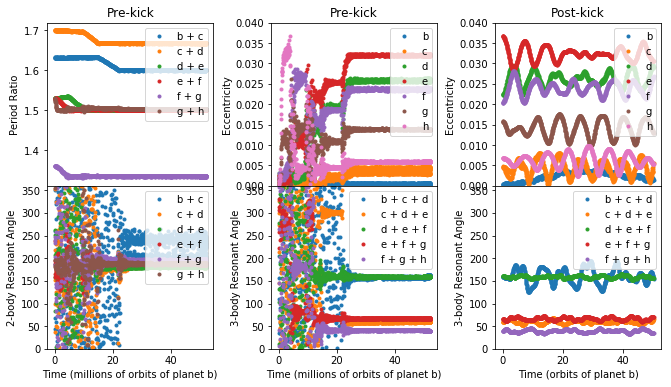

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, axarr = plt.subplots(ncols=3, nrows=2, figsize=(11,6))

for p in planets:
    axarr[0,1].plot(np.array(t[p])/1e6, e[p], '.', label=p, rasterized=True)
    axarr[0,1].set_ylabel("Eccentricity")
    axarr[0,1].set_ylim([0.,0.04])
    axarr[0,2].plot(tkick[p], ekick[p], '.', label=p, rasterized=True)
    axarr[0,2].set_ylabel("Eccentricity")
    axarr[0,2].set_ylim([0.,0.04])
for resonance in resonances.items():
    pair = resonance[0]
    res = resonance[1]
    axarr[0,0].plot(np.array(t[pair])/1e6, Pratio[pair], '.', label=pair[0]+" + "+pair[1], rasterized=True)
    axarr[0,0].set_ylabel("Period Ratio")
    if res is not None:
        axarr[1,0].plot(np.array(t[pair])/1e6, phi1[pair], '.', label=pair[0]+" + "+pair[1], rasterized=True)
        axarr[1,0].set_ylabel("2-body Resonant Angle")
        axarr[1,0].set_ylim([0.,360])
for resonance in threebodyresonances.items():
    triad = resonance[0]
    axarr[1,1].plot(np.array(t[triad])/1e6, phi3body[triad], '.', label=triad[0]+ " + "+triad[1] + " + "+triad[2], rasterized=True)
    axarr[1,1].set_ylabel("3-body Resonant Angle")
    axarr[1,1].set_ylim([0.,360])
    axarr[1,2].plot(tkick[triad], phi3bodykick[triad], '.', label=triad[0]+ " + "+triad[1] + " + "+triad[2], rasterized=True)
    axarr[1,2].set_ylabel("3-body Resonant Angle")
    axarr[1,2].set_ylim([0.,360])
for ax in axarr.flatten():
    ax.legend(loc='upper right')
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.35)
axarr[1,0].set_xlabel("Time (millions of orbits of planet b)")
axarr[1,1].set_xlabel("Time (millions of orbits of planet b)")
axarr[1,2].set_xlabel("Time (orbits of planet b)")
axarr[0,0].set_title("Pre-kick")
axarr[0,1].set_title("Pre-kick")
axarr[0,2].set_title("Post-kick")

fig.savefig("fig1.pdf", bbox_inches='tight')